<a href="https://colab.research.google.com/github/MaxTechniche/DS20_Unit_1_Build/blob/master/Jacob_Maxfield_Unit_1_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDb Top 250 List**

###### Imports

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import defaultdict

##### Gather Datasets (Web Scraping)

###### Functions (I've already preprocessed it below.)

In [2]:
def convert_runtime(time):
  """Converts a string movie runningtime "#h ##min" to a int of total minutes."""
  runtime = time.split()
  print(runtime)
  if len(runtime) > 1:
    hours = int(runtime[0][:-1])
    minutes = int(runtime[1][:-3])
  elif len(runtime) == 1:
    if runtime[0][-1:] == 'h':
      hours = int(runtime[0][:-1])
      minutes = 0
    else:
      minutes = int(runtime[0][:-3])
      hours = 0
  else:
    return None
  converted_time = hours * 60 + minutes

  return converted_time


def get_imdb_top_250():
  """Gets list of the top 250 IMDb movies Titles and IDs. Returns a dictionary."""
  t_url = "https://www.imdb.com/chart/top"
  source = requests.get(t_url).text
  soup = BeautifulSoup(source, 'html.parser')

  movie_links = soup.find('tbody', class_='lister-list').find_all('a')
  movie_titles = {title['href'][9:-1]:title.text for title in movie_links}
  return movie_titles


def movie_info(df):
  """Gets list of the top 250 IMDb movies extended info. Returns a dictionary."""
  imdb = "https://www.imdb.com/"
  movie_info = defaultdict(dict)

  for id in df['ID']:
    source = requests.get(imdb + 'title/tt' + id).text
    info = BeautifulSoup(source, 'lxml').find('div', class_='subtext')

    rating = info.next_element.strip()

    runtime = convert_runtime(info.time.text.strip())

    try:
      genres = ', '.join([genre.text.strip() for genre in info.find_all(href=re.compile('/search'))])
    except AttributeError:
      genres = None

    try:
      release_date = info.find(href=re.compile('/title/tt')).text.strip()
      release_country = re.search('\([\w ]+\)', release_date)
      if release_country:
        release_country = release_country.group(0)
        release_date = release_date.strip(release_country).strip()
        release_country = release_country.lstrip('(').rstrip(')')
    except AttributeError:
      release_date = None
      release_country = None
    for name, val in zip(['Rating', 'Runtime', 'Genres', 'Release_Date', 'Release_Country'], [rating, runtime, genres, release_date, release_country]):
      movie_info[id][name] = val
  return movie_info
  

def merge_title_data():
  """Merge titles and extended title info data sets."""
  movie_titles = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/data_sets/top_250_imdb_list.csv'
  extended_movie_info = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/data_sets/top_250_movies_info.csv'

  df_titles = pd.read_csv(movie_titles)
  df_info = pd.read_csv(extended_movie_info)

  df = pd.merge(df_titles, df_info, on='ID')
  df.to_csv('top_250_IMDb_movies.csv', index=False)
  return pd.read_csv('top_250_IMDb_movies.csv')


def get_int(comma_num):
  """Convert comma split number string into an int."""
  return int(''.join(comma_num.split(',')))


def get_rankings(df):
  """Scrape the star rankings of all the movies."""
  rankings_dict = defaultdict(dict)
  rank_names = [
      *[str(x) for x in range(10, 0, -1)],
      *['Rank_' + gender + star for gender in ['All_', 'Male_', 'Female_'] for star in ['All_Ages','<18','18-29','30-44','45+']],
      *['Count_' + gender + count for gender in ['All_', 'Male_', 'Female_'] for count in ['All_Ages','<18','18-29','30-44','45+']]]
  
  title_link = 'https://www.imdb.com/title/tt'
  ids = df['ID']

  for id in ids:
    search = title_link + id + 'ratings'
    page = BeautifulSoup(requests.get(search).text, 'lxml')

    rank_values = []

    # Total Stars
    rank_values.extend([get_int(r.text.strip()) for r in page.find_all('div', class_='leftAligned')[1:11]])
    rank_values.extend([float(r.text.strip()) for r in page.find_all('div', class_='bigcell')[:15]])
    rank_values.extend([get_int(r.text.strip()) for r in page.findAll('a', href=re.compile('/title/tt' + id + 'ratings\?demo'))[:15]])
    
    for name, val in zip(rank_names, rank_values):
      rankings_dict[id][name] = val
  ranks = pd.DataFrame.from_dict(rankings_dict).T
  ranks.reset_index().rename({'index':'ID'}, axis=1).to_csv('top_250_rankings.csv', index=False)
  return pd.read_csv('top_250_rankings.csv')


###### Do not uncomment unless you want to scrape. It will take awhile (also, you'll probably encounter errors because I had to switch between Google Colab and local computer a few times.

In [3]:
# imdb = "https://www.imdb.com/"

# titles = imdb_top_titles()
# df = pd.DataFrame.from_dict(data=movie_info(titles, imdb)).T
# df = df.reset_index().rename(columns={'index':'ID'})

# df = merge_title_data()

# Full Movie Titles link
# movies_link = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/data_sets/top_250_IMDb_movies.csv'
# df = pd.read_csv(movies_link)

# rankings = get_rankings(df)
# df = pd.merge(df, rankings, on='ID')
# df['Release_Date'][51] = 'September 1954'
# df['Release_Date'] = pd.to_datetime(df['Release_Date'])
# df.to_csv('IMDb_Top_250.csv', index=False)

# Start here:

In [4]:
# Load in the data set!
imdb_list = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/data_sets/IMDb_Top_250.csv'
df = pd.read_csv(imdb_list)

# A few unknowns and generally the same ratings so I merged all similar ratings.
rating_system = {'Passed':'Other','Approved':'Other','GP':'Other',np.NaN:'Not Rated','':'Not Rated'}
df['Rating'] = df['Rating'].replace(rating_system)

In [5]:
# Removing hyphens so I can eval them.
df['Genres'] = df['Genres'].str.replace('Sci-Fi','SciFi')
df['Genres'] = df['Genres'].str.replace('Film-Noir','FilmNoir')

In [6]:
# Convert Release_Date to datetime object
df['Release_Date'] = pd.to_datetime(df['Release_Date'])
df['Release_Date'].value_counts().head()

1982-06-25    2
1995-11-22    2
2019-11-15    2
1994-10-14    2
2003-03-28    2
Name: Release_Date, dtype: int64

**SAME DAY RELEASES?!**

In [7]:
# Creating dataframe of release date pairs
rd_pairs = df[df['Release_Date'].isin(df['Release_Date'].value_counts().head(5).index)]
rd_pairs = rd_pairs.sort_values(['Release_Date', 'Rank_All_All_Ages'])

#### Explanitory Graph of Release Date Pairs

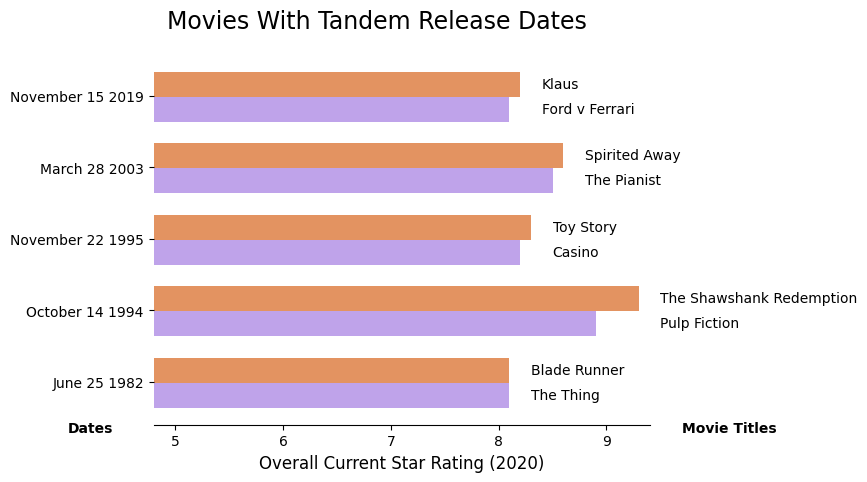

In [8]:
# Plotting those release date pairs

barHeight = 0.35

ranks1 = rd_pairs['Rank_All_All_Ages'][::2]
ranks2 = rd_pairs['Rank_All_All_Ages'][1::2]

names1 = rd_pairs['Title_Name'][::2]
names2 = rd_pairs['Title_Name'][1::2]

bar1 = np.arange(len(ranks1)) -.19
bar2 = [y + barHeight for y in bar1]

plt.style.use('default')

plt.barh(bar1, ranks1, barHeight, color='#BFA3EA')
plt.barh(bar2, ranks2, barHeight, color='#E39361')

plt.yticks(bar1+.19, [' '.join([d.month_name(), str(d.day), str(d.year)]) for d in pd.Series(rd_pairs['Release_Date'].unique())])
plt.xticks(range(5, 11))

plt.xlabel('Overall Current Star Rating (2020)',size=12)

plt.title('Movies With Tandem Release Dates', x=.45, y=1.05, size=17)

for x, y, name in zip([*ranks2, *ranks2], [*bar1, *bar2], [*rd_pairs['Title_Name'][::2], *rd_pairs['Title_Name'][1::2]]):
  plt.text(x+.2, y-.05, name)

for spine in ['right', 'top', 'left']:
  plt.gca().spines[spine].set_visible(False)

plt.text(4, -.7, 'Dates',weight='bold')
plt.text(9.7, -.7, 'Movie Titles', weight='bold')

plt.xlim(4.8, 9.4)

plt.savefig('tandem_release_dates.png', bbox_inches='tight')

plt.show()

#### Other EDA

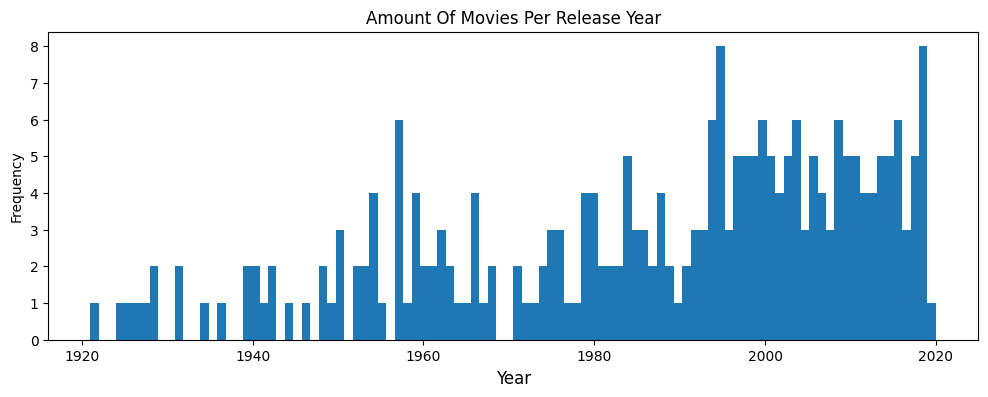

In [9]:
# Plotting number of Releases in each year
plt.figure(figsize=(12, 4))
df['Year'].plot.hist(bins=100)
plt.title('Amount Of Movies Per Release Year')
plt.xlabel('Year', size=12)

plt.savefig('movies_per_year.png', bbox_inches='tight')

plt.show()

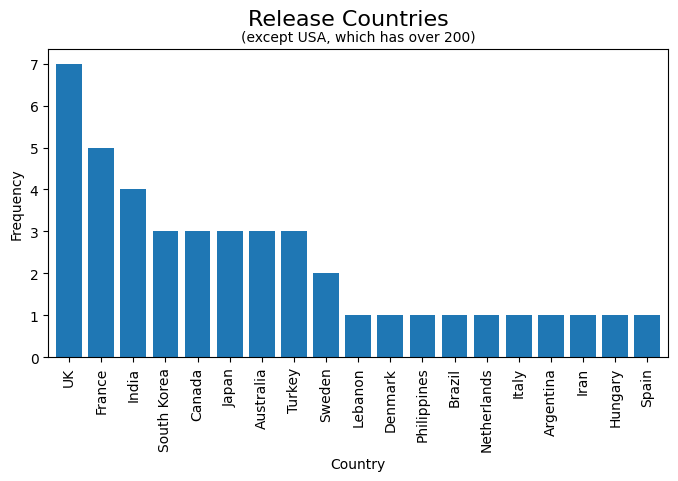

In [10]:
# Plotting releases not in USA
plt.figure(figsize=(8, 4))
df['Release_Country'].value_counts()[1:].plot.bar(width=.8)
plt.title('(except USA, which has over 200)', size=10)
plt.suptitle('Release Countries', size=16)
plt.ylabel('Frequency')
plt.xlabel('Country')

plt.savefig('release_countries.png', bbox_inches='tight')

plt.show()

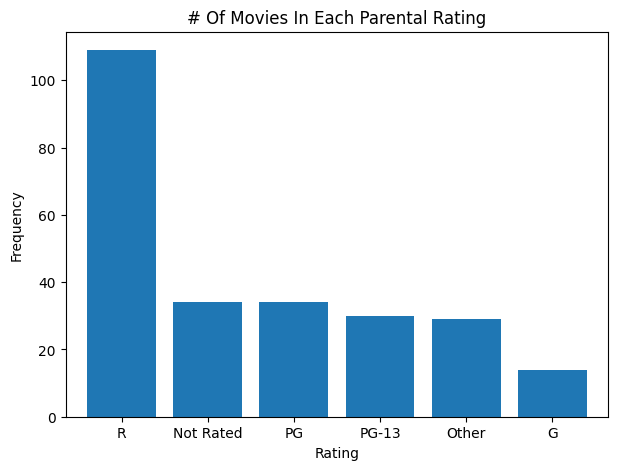

In [11]:
# Plotting Parental ratings
plt.figure(figsize=(7, 5))
df['Rating'].value_counts().plot.bar(width=.8, rot=0)
plt.title('# of movies in each parental rating'.title())
plt.ylabel('Frequency')
plt.xlabel('Rating')

plt.savefig('parental_rating.png', bbox_inches='tight')

plt.show()

In [12]:
# Get set of genres
genres = list(set([genre for x in df['Genres'] for genre in x.split(', ')]))

In [13]:
# Evaluating genres so I don't have to write them all out! 
genre_dfs = []
for genre in genres:
  globals()[genre] = df[df['Genres'].str.contains(genre)]
  genre_dfs.append(eval(genre))

In [14]:
# Creating dictionaries of the names of the genres and the movies they're associated with for both rankings and vote counts
genre_rank_dict = {}

for genre_name, genre_df in zip(genres, genre_dfs):
  genre_rank_dict[genre_name] = genre_df[[column for column in genre_df.columns if 'Rank' in column]]

genre_count_dict = {}

for genre_name, genre_df in zip(genres, genre_dfs):
  genre_count_dict[genre_name] = genre_df[[column for column in genre_df.columns if 'Count' in column]]

In [15]:
# Couldn't think of a better way to get the genres as an index for the described data sets
genre_list = []
for genre_mult in [[genre] * 4 for genre in genres]:
  genre_list.extend(genre_mult)

In [16]:
# I describe the dataframe and grab only the mean, std, min, and max rows
describe_rank_df = pd.DataFrame(columns=['index'] + [column for column in genre_rank_dict['Action'].columns if 'Rank_' in column])
for genre in genres:
  g_df = genre_rank_dict[genre].describe().T[['mean','std','min','max']].T.reset_index().rename({'index':'type'})
  g_df.index = [genre]*4
  describe_rank_df = describe_rank_df.append(g_df)
rank_mean_df = describe_rank_df[describe_rank_df['index'] == 'mean'].sort_values('Rank_All_All_Ages')

In [17]:
# Describe for count now
describe_count_df = pd.DataFrame(columns=['index'] + [column for column in genre_count_dict['Action'].columns if 'Count_' in column])
for genre in genres:
  g_df = genre_count_dict[genre].describe().T[['mean','std','min','max']].T.reset_index().rename({'index':'type'})
  g_df.index = [genre]*4
  describe_count_df = describe_count_df.append(g_df)
count_mean_df = describe_count_df[describe_count_df['index'] == 'mean'].sort_values('Count_All_All_Ages').round()

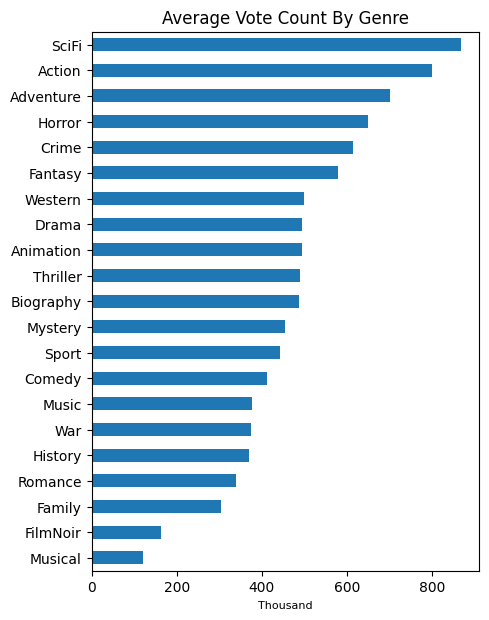

In [18]:
# Plotting Average vote count by genre
plt.figure(figsize=(5,7))
count_mean_df['Count_All_All_Ages'].plot.barh()
plt.xlabel('Thousand', size=8)
plt.title('Average Vote Count By Genre')
plt.xticks([0,200000,400000,600000,800000], [0, 200, 400, 600, 800])
plt.show()

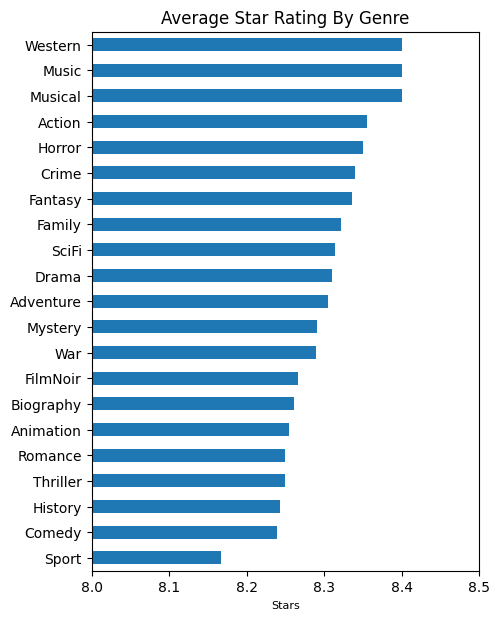

In [19]:
# Plotting average star rank per genre
plt.figure(figsize=(5,7))
rank_mean_df['Rank_All_All_Ages'].plot.barh()
plt.xlabel('Stars', size=8)
plt.title('Average Star Rating By Genre')
plt.xlim(8, 8.5)
plt.show()

In [20]:
# Creating a mapping so I can cross plot the ranks and votes per genre
mapping = {val:i for val, i in zip(rank_mean_df['Rank_All_All_Ages'].sort_values().index.tolist(), range(len(genres)))}

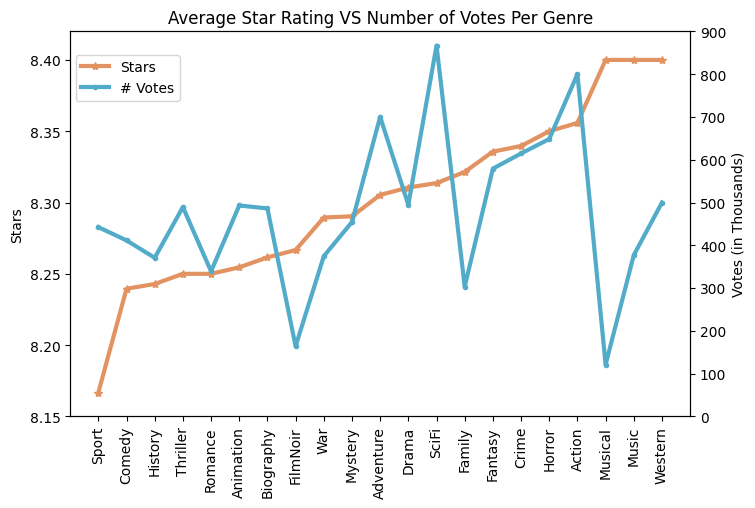

In [21]:
# Plotting average star rank to average votes per genre
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(range(len(genres)), rank_mean_df['Rank_All_All_Ages'], color='#E39361', marker='*', lw=3)
ax1.set_xticks(range(len(genres)))
ax1.set_xticklabels(rank_mean_df['Rank_All_All_Ages'].index, rotation=90)
ax1.set_ylim(8.15, 8.42)
ax1.set_ylabel('Stars')

ax2 = ax1.twinx()
ax2.plot(range(len(genres)), [count_mean_df['Count_All_All_Ages'][genre] for genre in mapping.keys()], color='#52ACC9', marker='.', lw=3)
ax2.set_ylim(0, 900000)
ax2.set_yticklabels(np.arange(0, 10)*100)
ax2.set_ylabel('Votes (in Thousands)')

ax2.set_title('Average Star Rating VS Number of Votes Per Genre')

fig.legend(['Stars', '# Votes'], loc=(.1, .8))

plt.savefig('genre_votes_and_star_rating.png', bbox_inches='tight')

plt.show()

In [22]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
# Grabbing the correlation between the vote count and the star ranking
df[['Rank_All_All_Ages', 'Count_All_All_Ages']].corr()


,Rank_All_All_Ages,Count_All_All_Ages
Rank_All_All_Ages,1.000000,0.592194
Count_All_All_Ages,0.592194,1.000000


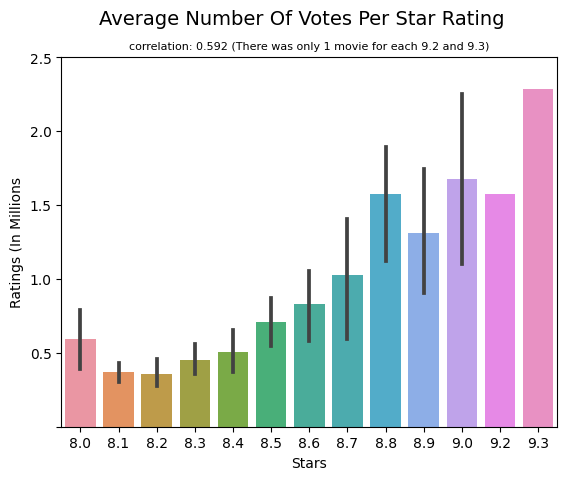

In [24]:
# Plotting Votes vs Ranking
sns.barplot('Rank_All_All_Ages', 'Count_All_All_Ages', data=df)
plt.title('correlation: 0.592 (There was only 1 movie for each 9.2 and 9.3)', size=8)
plt.ylabel('Ratings (In Millions')
plt.xlabel('Stars')

plt.yticks([0,.5e6,1e6,1.5e6,2e6,2.5e6], ['', '0.5','1.0','1.5','2.0','2.5'])

plt.suptitle('Average Number Of Votes Per Star Rating', size=14)

plt.savefig('stars_to_num_ratings.png', bbox_inches='tight')

plt.show()

Average Rating Per Year


In [25]:
# I could probably streamline this cell
# I'm creating a bunch of lists and storing the cumulative averages and instance averages over the years the movies were released
year_averages = []
year_male_averages = []
year_female_averges = []
current_male = []
current_female = []
current = []
for year in range(1920, 2021):
  current_year = df[df['Year'] == year]
  year_check = df[df['Year'] <= year]
  year_averages.append(year_check['Rank_All_All_Ages'].mean())
  males = year_check['Rank_Male_All_Ages']
  females = year_check['Rank_Female_All_Ages']
  year_male_averages.append(males.mean())
  year_female_averges.append(females.mean())

  if len(current_year):
    current.append(current_year['Rank_All_All_Ages'].mean())
    current_male.append(current_year['Rank_Male_All_Ages'].mean())
    current_female.append(current_year['Rank_Female_All_Ages'].mean())
  elif current_male:
    current.append(current[-1])
    current_male.append(current_male[-1])
    current_female.append(current_female[-1])
  else:
    current.append(year_averages[-1])
    current_male.append(males.mean())
    current_female.append(females.mean())

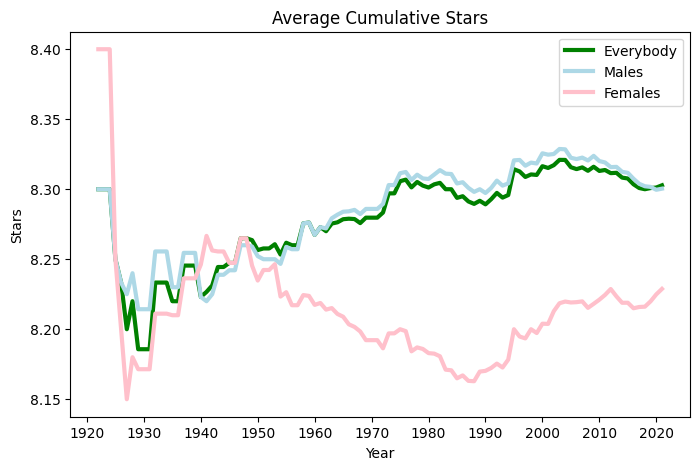

In [26]:
# Then I plot it
plt.figure(figsize=(8, 5))

xs = list(range(-1, 100))

plt.plot(year_averages, lw=3, color='g')
#plt.plot(current, color='g')

plt.plot(year_male_averages, lw=3, color='lightblue')
#plt.plot(current_male, color='lightblue')

plt.plot(year_female_averges, lw=3, color='pink')
#plt.plot(current_female, color='pink')


plt.xticks(range(-1, 100, 10), [str(x) for x in range(1920, 2021, 10)])
# plt.ylim(0, 8.4)
plt.title('Average Cumulative Stars')
plt.ylabel('Stars')
plt.xlabel('Year')

plt.legend(['Everybody', 'Males', 'Females'])

plt.savefig('average_stars.png', bbox_inches='tight')

plt.show()

In [27]:
# Getting the ranks for each group of people and removing 'Rank_' from the name
rank_grouping = df[[name for name in df.columns if 'Rank_' in name]]
rank_grouping.columns = rank_grouping.columns.str.replace('Rank_','')
rank_grouping.columns = rank_grouping.columns.str.replace('_',' ')

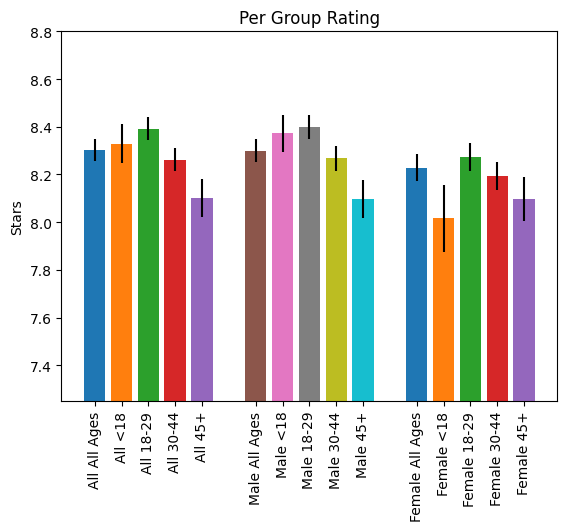

In [28]:
# Plotting each group
for x, column in zip(list(range(5)) + list(range(6, 11)) + list(range(12, 17)), rank_grouping):
  plt.bar(x, rank_grouping[column].mean(), yerr=rank_grouping[column].std()/5)
plt.xticks(list(range(5)) + list(range(6, 11)) + list(range(12, 17)), rank_grouping, rotation=90)
plt.ylim(7.25, 8.8)

plt.ylabel('Stars')
plt.title('Per Group Rating')

plt.savefig('group_ranking.png', bbox_inches='tight')

plt.show()